# MAP for NRC

In [1]:
import geopandas as gpd
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/Users/Ruhama/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Master thesis'

## Barangay shape file

This section involves working with barangay-level shapefiles for the Philippines. The shapefiles are loaded and processed using the GeoPandas library. The data is visualized to understand the geographic distribution and boundaries of barangays, with a specific focus on the National Capital Region (NCR).

from GitHub by the standard of December 2023  
[https://github.com/altcoder/philippines-psgc-shapefiles?tab=readme-ov-file](https://github.com/altcoder/philippines-psgc-shapefiles?tab=readme-ov-file)

In [3]:
# Load the shapefile
shapefile_path = DATA_PATH + '/Shape files/Philippines PSGC Bgy Sub Muns/BgySubMuns.shp.shp'
shape_data = gpd.read_file(shapefile_path)

# Display the first few rows of the shapefile data
# print(shape_data.head())

In [4]:
# Load the shapefile
shapefile_path_2 = DATA_PATH + '/Shape files/Philippines PSGC Bgy Sub Muns/PH_Adm4_BgySubMuns.shp.shp'
shape_data_2 = gpd.read_file(shapefile_path_2)

# Display the first few rows of the shapefile data
# shape_data_2

In [5]:
shape_NCR = shape_data_2[shape_data_2['adm1_psgc'] == 1300000000]

<Axes: >

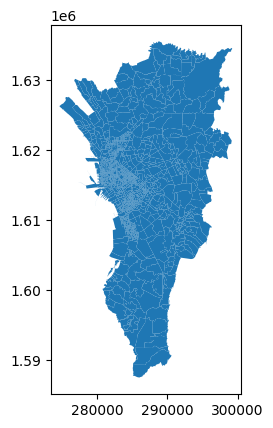

In [6]:
shape_NCR.plot()

In [7]:
shape_NCR["adm4_en"].unique()

array([None, 'Barangay 1', 'Barangay 2', ..., 'Santo Rosario-Kanluran',
       'Santo Rosario-Silangan', 'Tabacalera'], dtype=object)

In [8]:
# 2. Define which three you want to highlight.
#    You can pick them by name, by index, or whatever attribute uniquely identifies them.
highlight_list = [1380601020,1380601128,1380613001, 1381300022, 	1381300010, 1381300138]
shape_NCR["is_highlight"] = shape_NCR["adm4_psgc"].isin(highlight_list)

/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
highlight_list = [1380601020,1380601128,1380613001 
                #   1381300022, 	1381300010, 1381300138
                ]
shape_NCR["is_highlight"] = shape_NCR["adm4_psgc"].isin(highlight_list)

In [10]:
slum = shape_NCR[shape_NCR["is_highlight"]]
slum = slum.to_crs(epsg=4326)

## DHS data - wealth ranking

In [11]:
# Load the Stata file
stata_file_path = DATA_PATH + '/Shared_DHS/PH_2022_DHS_02282025_1112_220775/PHHR82DT/PHHR82FL.DTA'
stata_data = pd.read_stata(stata_file_path, convert_categoricals=False)


# Display the first few rows of the data
# print(stata_data.head())

In [12]:
# Keep only the specified columns in household_data
household_data = stata_data[['hhid', 'hv001', 'hv005', 'hv270', 'hv271', 'sh136a']]
# household_data.head()

In [13]:
household_data['hv005'] = household_data['hv005'] / 1000000
household_data['hv005'].astype(float)  

/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_83487/1458322482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  household_data['hv005'] = household_data['hv005'] / 1000000


0        0.118019
1        0.118019
2        0.118019
3        0.118019
4        0.118019
           ...   
30367    0.700689
30368    0.700689
30369    0.700689
30370    0.700689
30371    0.700689
Name: hv005, Length: 30372, dtype: float64

In [14]:
# Load the shapefile
ge_shapefile_path = DATA_PATH + '/DHS/PH_2022_DHS_11032024_52_220775/PHGE81FL/PHGE81FL.shp'
ge_shape_data = gpd.read_file(ge_shapefile_path)



In [15]:
# Merge ge_shape_data and household_data using DHSCLUST (ge_shape_data) and hv001 (household_data)
merged_data = ge_shape_data.merge(household_data, left_on='DHSCLUST', right_on='hv001', how='inner')
merged_data = merged_data[merged_data['ADM1DHS'] == 13.0]


<Axes: >

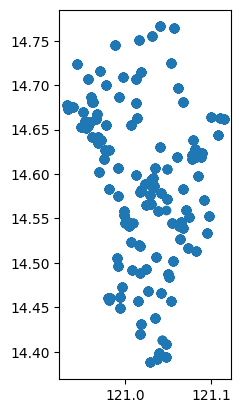

In [16]:
merged_data.plot()


### Average wealth ranking

In [17]:
import numpy as np

cluster_agg = merged_data.groupby('hv001').apply(lambda g: pd.Series({
    'hv270_mode': np.average(g['hv270'], weights=g['hv005']),
    'hv271_mean': np.average(g['hv271'], weights=g['hv005']),
    'count': g.shape[0]
})).reset_index()

# cluster_agg.head()


/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_83487/2236637730.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_agg = merged_data.groupby('hv001').apply(lambda g: pd.Series({


In [18]:
# Merge cluster_agg and merged_data on 'hv001'
merged_with_agg = merged_data.merge(cluster_agg, on='hv001', how='left')
# merged_with_agg.head()

In [19]:
# Project to a metric CRS (e.g., UTM zone 51N for NCR)
pts_m = merged_with_agg.to_crs(epsg=32651)

# Create 2 km buffers (radius = 2000 meters)
buffers = pts_m.copy()
buffers['geometry'] = pts_m.geometry.buffer(2000)

# Convert buffers back to WGS84 for mapping
buffers = buffers.to_crs(epsg=4326)
# Rename 'hv270_mode' to 'wealth_q' if present
if 'hv270_mode' in buffers.columns:
    buffers = buffers.rename(columns={'hv270_mode': 'wealth_q'})

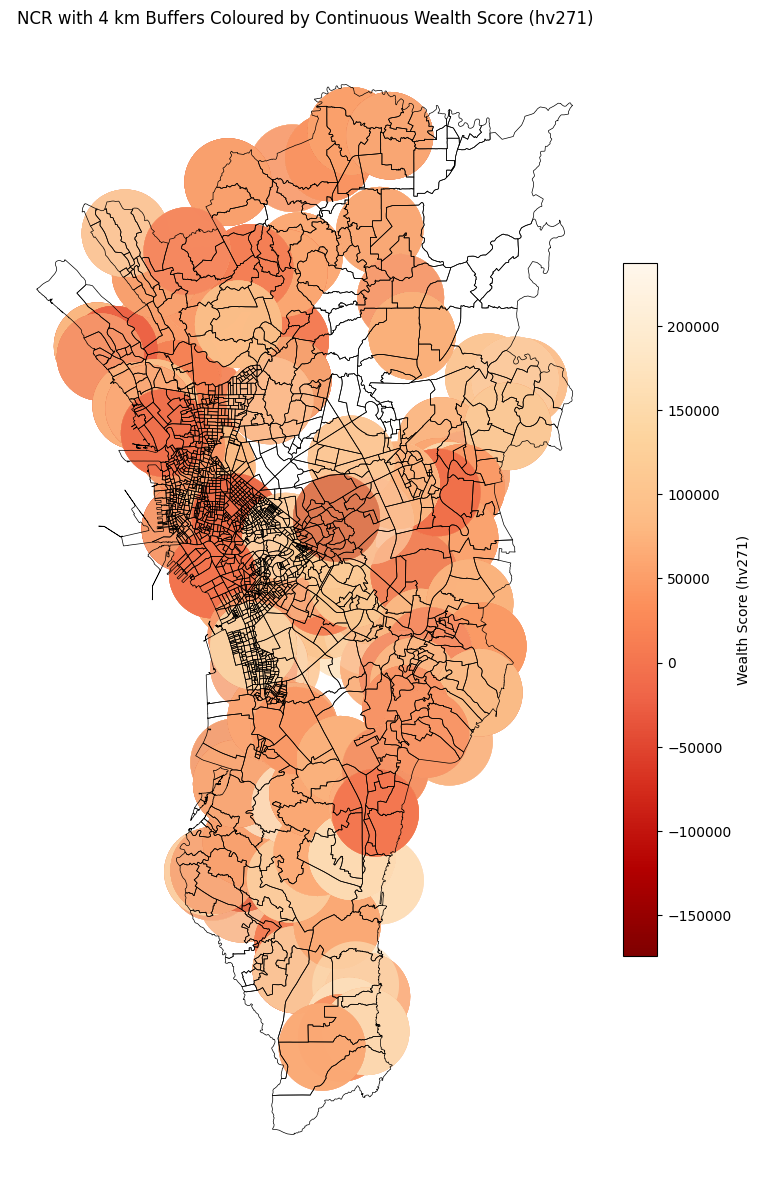

In [20]:

# 1) Metric CRS for buffering
shape_m = shape_NCR.to_crs(epsg=32651)
pts_m   = merged_data.to_crs(epsg=32651)

# 2) Create 2 km buffers → 4 km diameter
buffers = pts_m.copy()
buffers['geometry'] = buffers.geometry.buffer(2000)

# 3) Back to WGS84 for plotting
shape_wgs   = shape_m.to_crs(epsg=4326)
buffers_wgs = buffers.to_crs(epsg=4326)

# 4) Plot continuous hv271 with a colorbar
fig, ax = plt.subplots(figsize=(15, 15))

# Plot buffers colored by hv271
cax = buffers_wgs.plot(
    ax=ax,
    column='hv271',        # use continuous wealth score
    cmap='OrRd_r',         # reversed so low scores are dark
    legend=True,           # draws a colorbar
    legend_kwds={
        'label': "Wealth Score (hv271)",
        'shrink': 0.6,
        'orientation': 'vertical',
        'pad': 0.02
    },
    edgecolor='none',
    alpha=0.3,
    zorder=1
)

# Draw barangay lines on top
shape_wgs.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

# Add title, remove axes
plt.title('NCR with 4 km Buffers Coloured by Continuous Wealth Score (hv271)')
plt.axis('off')

plt.show()


In [21]:

merged_with_agg = merged_with_agg.drop_duplicates(subset=['hv001', 'hv270_mode'])

In [22]:
# 0.  START:  point layer  «merged_with_agg»
#     • geometry  (EPSG:4326, lon/lat)
#     • wealth column  hv270_mode  ← to be averaged
# ────────────────────────────────────────────────────────────────
gdf0 = merged_with_agg.copy()

# unify the wealth column name
if "hv270_mode" in gdf0.columns:
    gdf0 = gdf0.rename(columns={"hv270_mode": "wealth_q"})

# ────────────────────────────────────────────────────────────────
# 1.  Re-project to a **metric CRS**  (UTM-51 N  → EPSG:32651)
# ────────────────────────────────────────────────────────────────
CRS_METRIC = 32651
gdf_pts = gdf0.to_crs(epsg=CRS_METRIC)

# ────────────────────────────────────────────────────────────────
# 2.  Build the 2 km buffers
# ────────────────────────────────────────────────────────────────
gdf_buf = gdf_pts.copy()
gdf_buf["geometry"] = gdf_pts.geometry.buffer(2000)      # metres

# Reproject buffer GeoDataFrame to match shape_wgs CRS (EPSG:4326)
gdf_buf = gdf_buf.to_crs(shape_wgs.crs)

# 1.  Load / prepare the boundary polygon  (same CRS as buffers_wgs)
boundary = shape_wgs

# 2.  Clip the buffers
buffers_clipped = gpd.clip(gdf_buf, boundary)


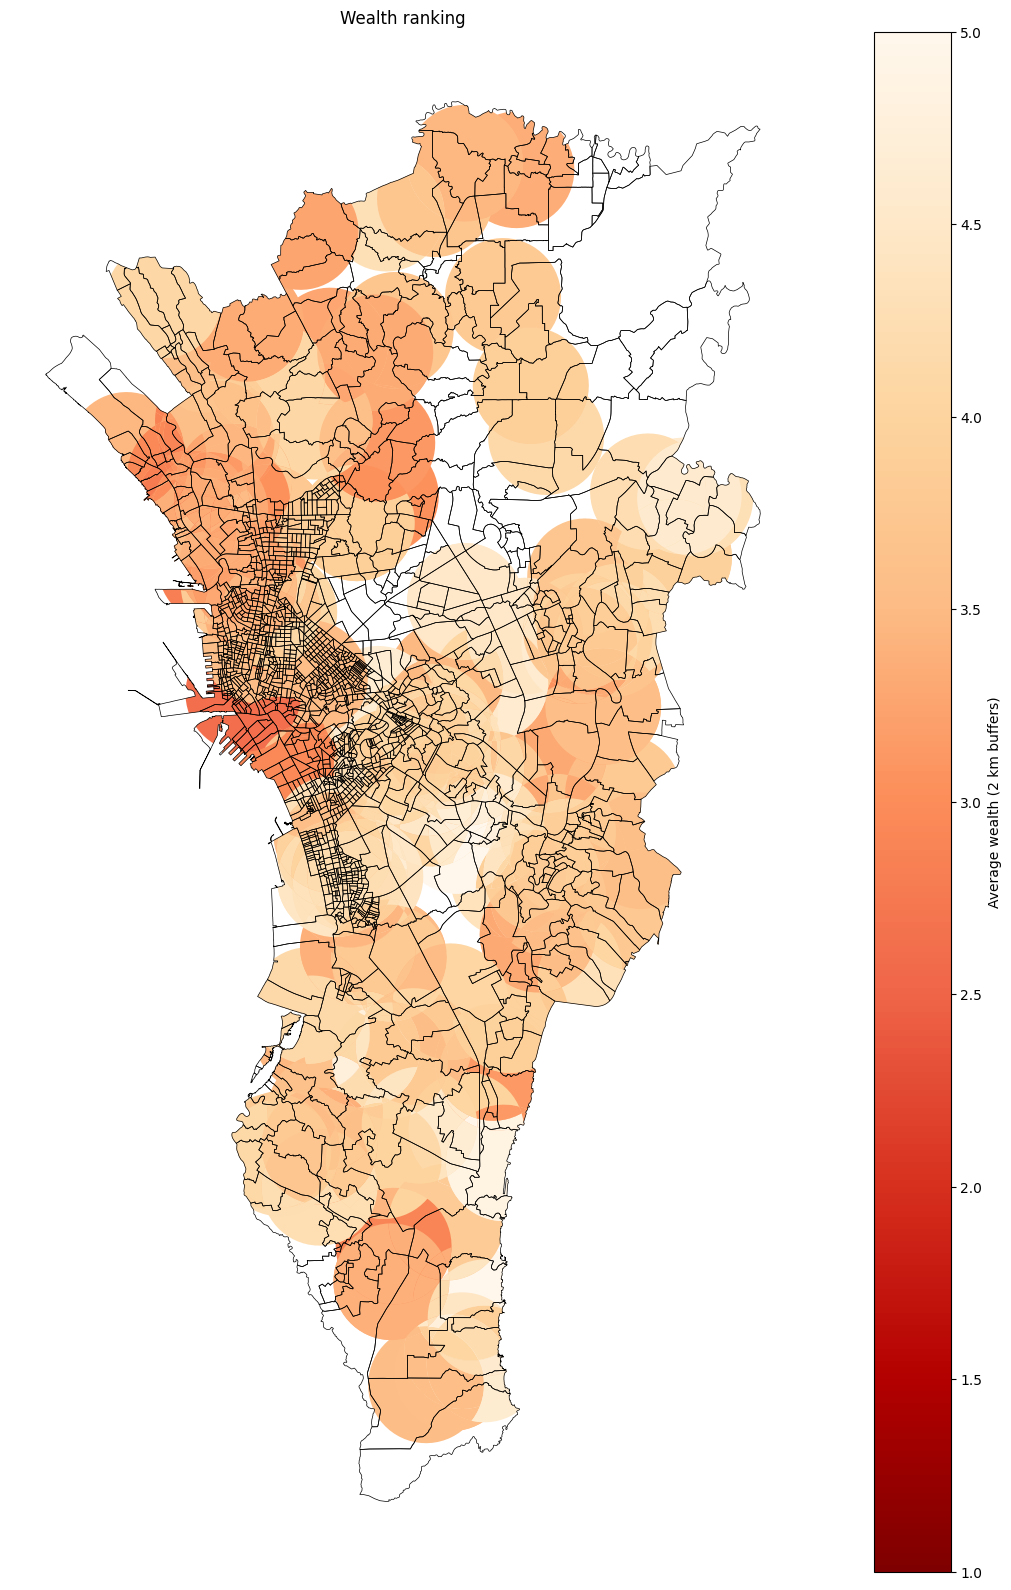

In [23]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize
import pandas as pd

# ────────────────────────────────────────────────────────────────
# 0.  START:  point layer  «merged_with_agg»
#     • geometry  (EPSG:4326, lon/lat)
#     • wealth column  hv270_mode  ← to be averaged
# ────────────────────────────────────────────────────────────────
gdf0 = merged_with_agg.copy()

# unify the wealth column name
if "hv270_mode" in gdf0.columns:
    gdf0 = gdf0.rename(columns={"hv270_mode": "wealth_q"})

# ────────────────────────────────────────────────────────────────
# 1.  Re-project to a **metric CRS**  (UTM-51 N  → EPSG:32651)
# ────────────────────────────────────────────────────────────────
CRS_METRIC = 32651
gdf_pts = gdf0.to_crs(epsg=CRS_METRIC)

# ────────────────────────────────────────────────────────────────
# 2.  Build the 2 km buffers
# ────────────────────────────────────────────────────────────────
gdf_buf = gdf_pts.copy()
gdf_buf["geometry"] = gdf_pts.geometry.buffer(2000)      # metres

# ────────────────────────────────────────────────────────────────
# 3.  Split the **whole footprint** into non-overlapping “atoms”
#     • merge *all* buffer boundaries
#     • polygonise the merged linework → atomic polygons
# ────────────────────────────────────────────────────────────────
# 3a  collect every circle’s boundary as a single MultiLineString
merged_edges = unary_union(gdf_buf.boundary)

# 3b  polygonise those lines → generator of Shapely polygons
atoms = list(polygonize(merged_edges))

# 3c  keep only polygons actually inside the union of buffers
union_buf = unary_union(gdf_buf.geometry)
atoms = [p for p in atoms if p.intersects(union_buf) and not p.is_empty]

gdf_atoms = gpd.GeoDataFrame(geometry=atoms, crs=CRS_METRIC)

# Optional: remove tiny slivers (e.g., < 5 m²)
MIN_AREA_M2 = 5.0
gdf_atoms = gdf_atoms[gdf_atoms.area >= MIN_AREA_M2]

# ────────────────────────────────────────────────────────────────
# 4.  For every atom, collect the buffers that cover it
#     and compute count + mean wealth
# ────────────────────────────────────────────────────────────────
joined = gpd.sjoin(
    gdf_atoms,                                 # left  – atomic areas
    gdf_buf[["wealth_q", "geometry"]],         # right – buffers (+ wealth)
    how="left",
    predicate="covered_by"                         # buffer fully covers patch
)

stats = (
    joined.groupby(joined.index)
          .agg(num_buf   = ("wealth_q", "size"),
               avg_wealth= ("wealth_q", "mean"))
)

gdf_atoms = gdf_atoms.join(stats)

# ────────────────────────────────────────────────────────────────
# 5.  Back to WGS-84 if you want to map / export
# ────────────────────────────────────────────────────────────────
gdf_atoms = gdf_atoms.to_crs(epsg=4326)
boundary = shape_wgs

# 2.  Clip the buffers
gdf_atoms_clipped = gpd.clip(gdf_atoms, boundary)
# 1) Metric CRS for buffering

#  gdf_atoms columns:
#    • geometry      – atomic patch (no overlaps with neighbours)
#    • num_buf       – 1, 2, 3 …   how many 2 km buffers cover it
#    • avg_wealth    – mean wealth_q of those buffers

# ────────────────────────────────────────────────────────────────
# 7.  Quick map:  avg_wealth as a choropleth,
#                 solo patches hatched + red outline
# ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

buffers_clipped.plot(
    column="wealth_q",
    cmap="OrRd_r",
    linewidth=0,
    ax=ax,
    legend=True,
    vmin=1, vmax=5,
    legend_kwds={"label": "Average wealth (2 km buffers)"}
)


#base: every atomic polygon coloured by mean wealth
gdf_atoms_clipped.plot(
    column="avg_wealth",
    cmap="OrRd_r",
    linewidth=0,
    ax=ax,
    legend=False,
    vmin=1, vmax=5,
    legend_kwds={"label": "Average wealth (2 km buffers)"}
)

# Draw barangay lines on top
shape_wgs.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

ax.set_title("Wealth ranking")
ax.axis("off")
plt.show()


In [24]:
# Save the last matplotlib figure to a file (e.g., PNG)
fig.savefig("picture/dhs_map.png", dpi=300, bbox_inches='tight')

### Minimum map

In [25]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize
import pandas as pd

merged_with_agg = merged_with_agg.sort_values(by="hv270_mode", ascending=False)

# ────────────────────────────────────────────────────────────────
# 0.  START:  point layer  «merged_with_agg»
#     • geometry  (EPSG:4326, lon/lat)
#     • wealth column  hv270_mode  ← to be averaged
# ────────────────────────────────────────────────────────────────
gdf0 = merged_with_agg.copy()

# unify the wealth column name
if "hv270_mode" in gdf0.columns:
    gdf0 = gdf0.rename(columns={"hv270_mode": "wealth_q"})

# ────────────────────────────────────────────────────────────────
# 1.  Re-project to a **metric CRS**  (UTM-51 N  → EPSG:32651)
# ────────────────────────────────────────────────────────────────
CRS_METRIC = 32651
gdf_pts = gdf0.to_crs(epsg=CRS_METRIC)

# ────────────────────────────────────────────────────────────────
# 2.  Build the 2 km buffers
# ────────────────────────────────────────────────────────────────
gdf_buf = gdf_pts.copy()
gdf_buf["geometry"] = gdf_pts.geometry.buffer(2000)      # metres

gdf_atoms_clipped = gpd.clip(gdf_buf.to_crs(4326), shape_wgs)

gdf_atoms_clipped = gdf_atoms_clipped.sort_values(by="wealth_q", ascending=False)

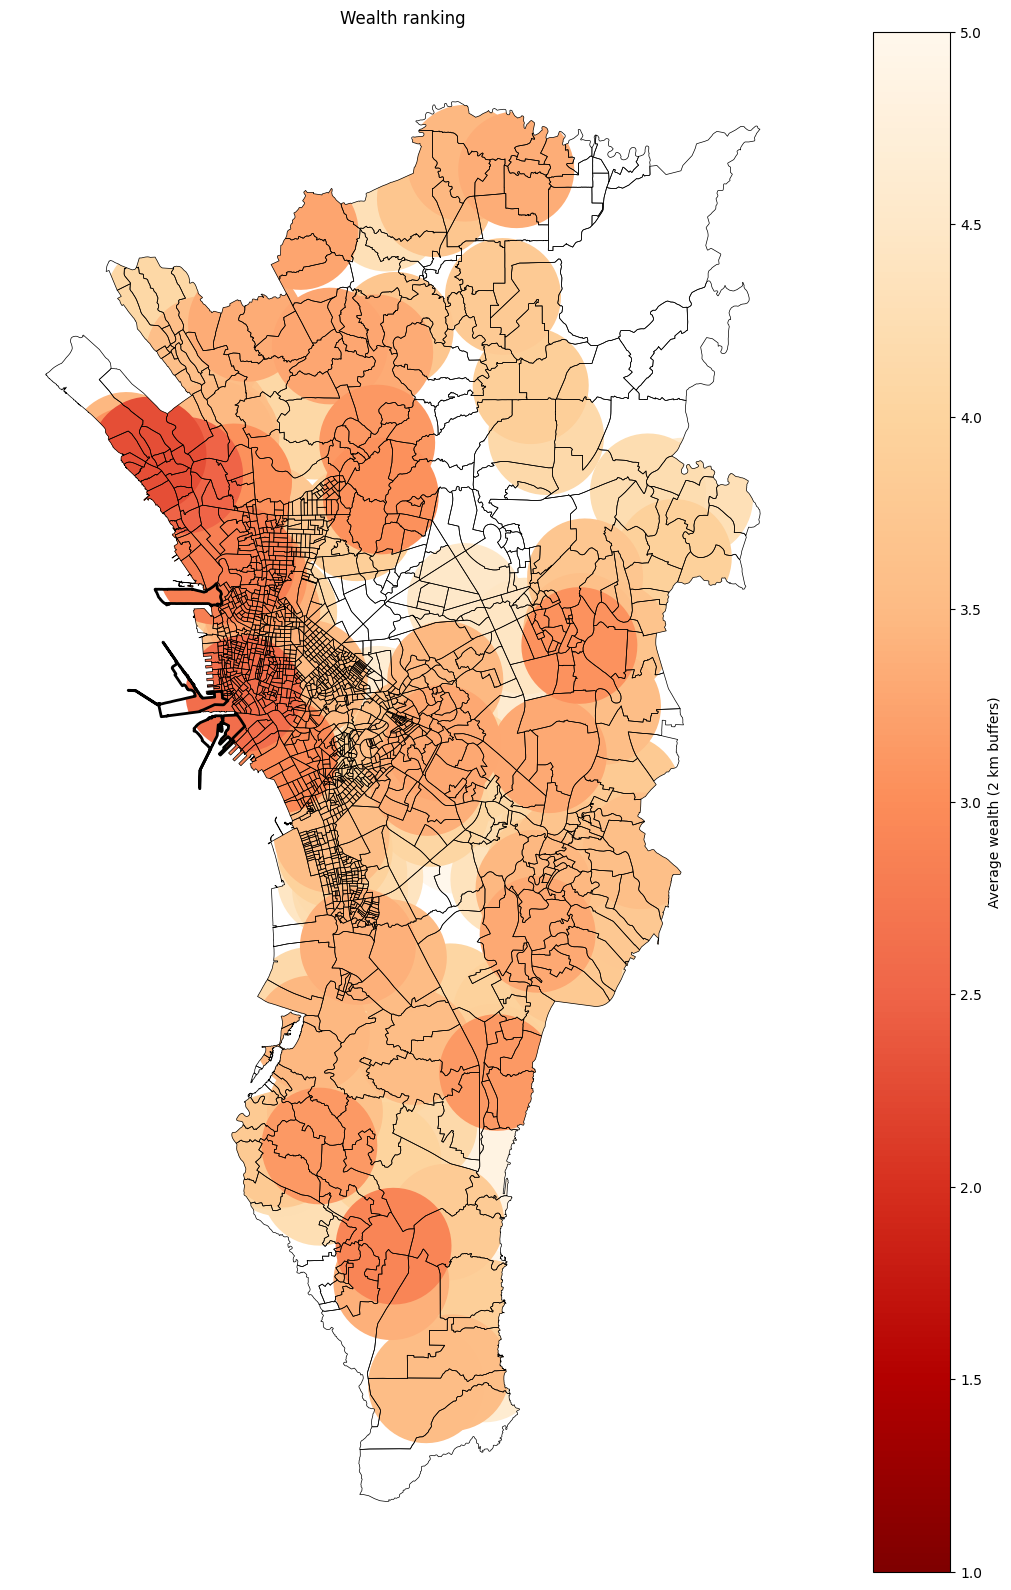

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

# buffers_clipped.plot(
#     column="wealth_q",
#     cmap="OrRd_r",
#     linewidth=0,
#     ax=ax,
#     legend=True,
#     vmin=1, vmax=5,
#     legend_kwds={"label": "Average wealth (2 km buffers)"}
# )


#base: every atomic polygon coloured by mean wealth
gdf_atoms_clipped.plot(
    column="wealth_q",
    cmap="OrRd_r",
    linewidth=0,
    ax=ax,
    legend=True,
    vmin=1, vmax=5,
    legend_kwds={"label": "Average wealth (2 km buffers)"}
)

# Draw barangay lines on top
shape_wgs.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

# Draw barangay lines on top
slum.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=2,
    zorder=2
)

ax.set_title("Wealth ranking")
ax.axis("off")
plt.show()

In [27]:
# Save the last matplotlib figure to a file (e.g., PNG)
fig.savefig("picture/dhs_map_min.png", dpi=300, bbox_inches='tight')

## Beneficiary data

In [28]:
# Calculate the number of households per cluster
households_per_cluster = merged_data.groupby('hv001').apply(lambda g: g['hv005'].sum()).reset_index(name='n_households')

# Calculate the sum of sh136a per cluster
sh136a_sum_by_cluster = merged_data.groupby('hv001').apply(lambda g: (g['sh136a'] * g['hv005']).sum()).reset_index(name='sh136a')

# Merge the two results
cluster_stats = pd.merge(sh136a_sum_by_cluster, households_per_cluster, on='hv001')

# Calculate the ratio
cluster_stats['sh136a_ratio'] = cluster_stats['sh136a'] / cluster_stats['n_households']
# cluster_stats.head()

/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_83487/2972235052.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  households_per_cluster = merged_data.groupby('hv001').apply(lambda g: g['hv005'].sum()).reset_index(name='n_households')
/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_83487/2972235052.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sh136a_sum_by_cluster = merged_da

In [29]:
part = merged_data.merge(cluster_stats, on='hv001', suffixes=('', '_sum'))
part = part.drop_duplicates(subset=['hv001', 'sh136a_ratio'])

In [30]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize
import pandas as pd

# ────────────────────────────────────────────────────────────────
# 0.  START:  point layer  «merged_with_agg»
#     • geometry  (EPSG:4326, lon/lat)
#     • wealth column  hv270_mode  ← to be averaged
# ────────────────────────────────────────────────────────────────
gdf0 = part.copy()
gdf0 = gdf0.rename(columns={"sh136a_ratio": "participation"})


# ────────────────────────────────────────────────────────────────
# 1.  Re-project to a **metric CRS**  (UTM-51 N  → EPSG:32651)
# ────────────────────────────────────────────────────────────────
CRS_METRIC = 32651
gdf_pts = gdf0.to_crs(epsg=CRS_METRIC)

# ────────────────────────────────────────────────────────────────
# 2.  Build the 2 km buffers
# ────────────────────────────────────────────────────────────────
gdf_buf = gdf_pts.copy()
gdf_buf["geometry"] = gdf_pts.geometry.buffer(2000)      # metres


# ────────────────────────────────────────────────────────────────
# 5.  Back to WGS-84 if you want to map / export
# ────────────────────────────────────────────────────────────────
buffer = gdf_buf.to_crs(epsg=4326)
boundary = shape_wgs

# 2.  Clip the buffers
buffers_clipped = gpd.clip(buffer, boundary)


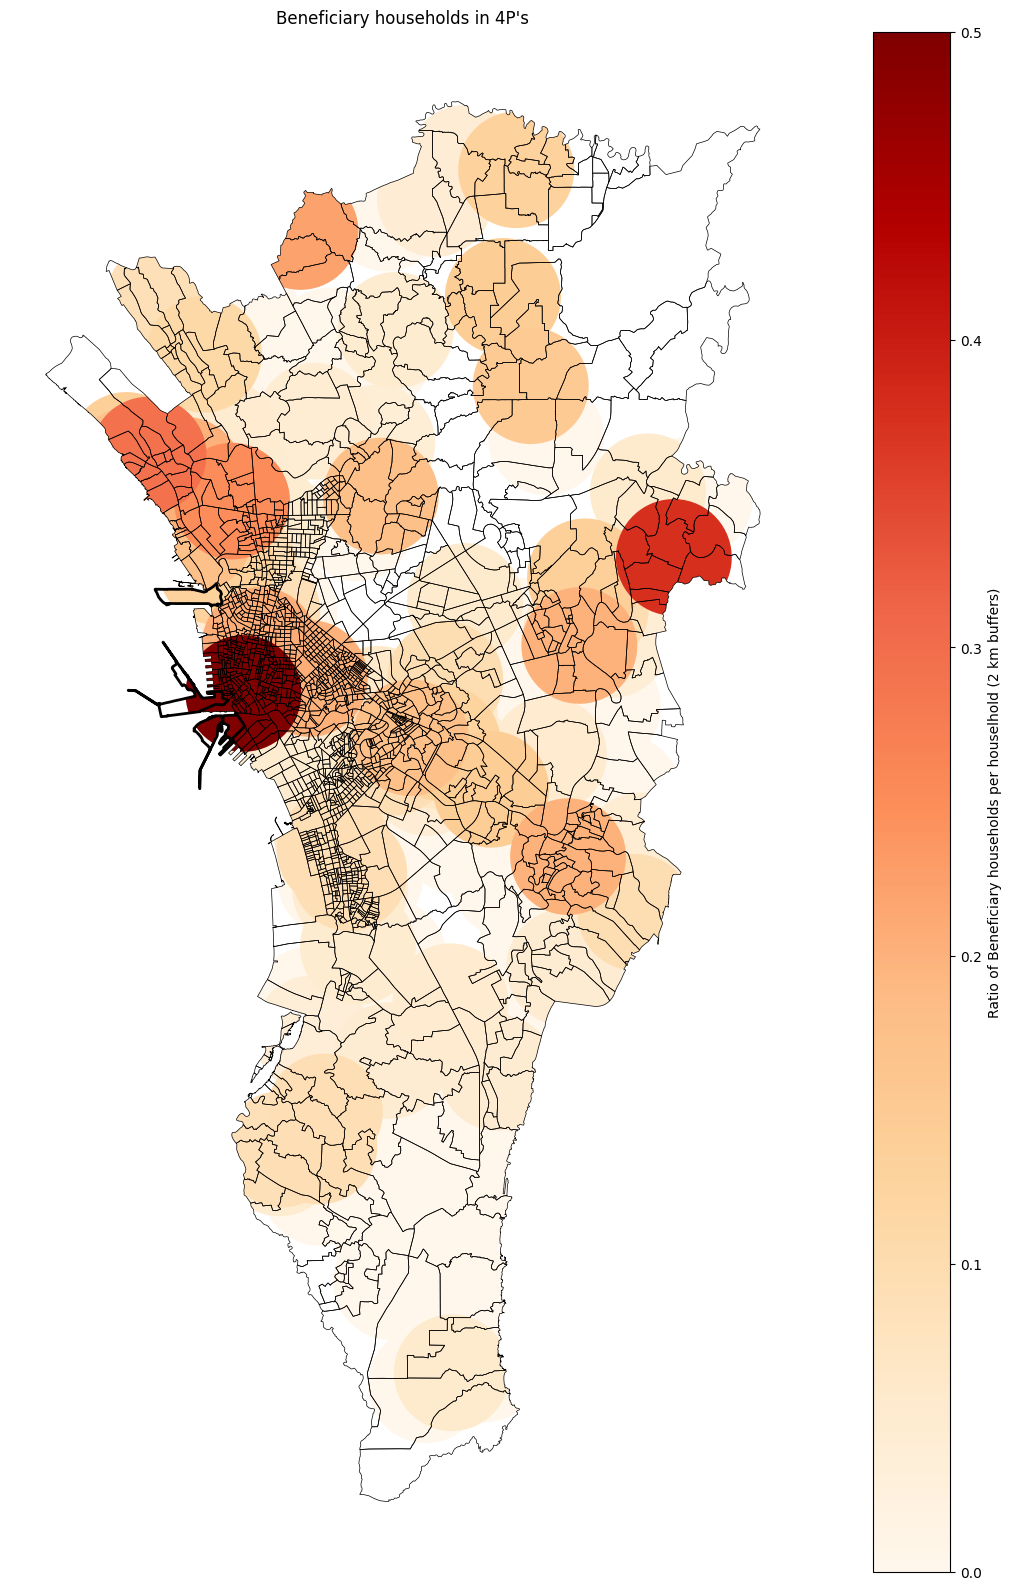

In [31]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize
import pandas as pd

# ────────────────────────────────────────────────────────────────
# 0.  START:  point layer  «merged_with_agg»
#     • geometry  (EPSG:4326, lon/lat)
#     • wealth column  hv270_mode  ← to be averaged
# ────────────────────────────────────────────────────────────────
gdf0 = part.copy()
gdf0 = gdf0.rename(columns={"sh136a_ratio": "participation"})


# ────────────────────────────────────────────────────────────────
# 1.  Re-project to a **metric CRS**  (UTM-51 N  → EPSG:32651)
# ────────────────────────────────────────────────────────────────
CRS_METRIC = 32651
gdf_pts = gdf0.to_crs(epsg=CRS_METRIC)

# ────────────────────────────────────────────────────────────────
# 2.  Build the 2 km buffers
# ────────────────────────────────────────────────────────────────
gdf_buf = gdf_pts.copy()
gdf_buf["geometry"] = gdf_pts.geometry.buffer(2000)      # metres

gdf_buf = gdf_buf.to_crs(epsg=4326)

gdf_atoms_clipped = gpd.clip(gdf_buf, shape_wgs)
gdf_atoms_clipped = gdf_atoms_clipped.sort_values(by="participation", ascending=True)




# ────────────────────────────────────────────────────────────────
# 7.  Quick map:  avg_wealth as a choropleth,
#                 solo patches hatched + red outline
# ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

# Plot atomic polygons colored by mean wealth
gdf_atoms_clipped.plot(
    column="participation",
    cmap="OrRd",
    linewidth=0,
    ax=ax,
    #vmin=0, vmax=0,8,
    legend=True,
    legend_kwds={"label": "Ratio of Beneficiary households per houselhold (2 km buffers)"}
)

# Draw barangay boundaries
shape_wgs.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

# Draw barangay lines on top
slum.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=2,
    zorder=2
)

ax.set_title("Beneficiary households in 4P's")
ax.axis("off")
plt.savefig("picture/participation_overlap_map.png", dpi=300, bbox_inches='tight')
plt.show()

## Calculating correlation 
between wealth and 4Ps participation on a household level


In [32]:
from scipy.stats import pointbiserialr, spearmanr
import numpy as np
from scipy.stats import t

# Add weights from hv005
w = stata_data['hv005']

# your data
x = stata_data['sh136a']   # participation indicator (0/1)
y = stata_data['hv270']    # wealth rank (1–5)

# Define a function to compute weighted Pearson correlation
def weighted_corr(x, y, weights):
    avg_x = np.average(x, weights=weights)
    avg_y = np.average(y, weights=weights)
    cov = np.average((x - avg_x) * (y - avg_y), weights=weights)
    std_x = np.sqrt(np.average((x - avg_x)**2, weights=weights))
    std_y = np.sqrt(np.average((y - avg_y)**2, weights=weights))
    return cov / (std_x * std_y)

# Compute weighted correlations
w_corr = weighted_corr(x, y, w)
print(f"Weighted Pearson correlation (using hv005 as weights): {w_corr:.3f}")

# Unweighted correlations
r_pb, p_pb = pointbiserialr(x, y)
print(f"Point-biserial correlation (sh136a vs. hv270): {r_pb:.3f} (p = {p_pb:.3g})")

# Estimate effective sample size using the given weights
n_eff = (w.sum())**2 / np.sum(w**2)

# Compute t-statistic and p-value for weighted Pearson correlation
t_val = w_corr * np.sqrt((n_eff - 2) / (1 - w_corr**2))
p_weighted_pearson = 2 * t.sf(np.abs(t_val), df=n_eff-2)
print(f"Weighted Pearson correlation p-value: {p_weighted_pearson:.3g}")


Weighted Pearson correlation (using hv005 as weights): -0.281
Point-biserial correlation (sh136a vs. hv270): -0.276 (p = 0)
Weighted Pearson correlation p-value: 0
